In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotnine as pn

In [2]:
def import_vsweep(fpath="schematic/data/dac7_L0.15W1vout-", num=2):
    list_df = []
    list_perchange = []
    for i in range(num):
        df_tmp = pd.read_csv(fpath+str(i+1)+".txt", delimiter="\s+")

        # Turn bits into binary
        df_tmp["v(b0)"] = (df_tmp["v(b0)"] > 1e-3).astype(float)
        df_tmp["v(b1)"] = (df_tmp["v(b1)"] > 1e-3).astype(float)
        df_tmp["v(b2)"] = (df_tmp["v(b2)"] > 1e-3).astype(float)
        df_tmp["v(b3)"] = (df_tmp["v(b3)"] > 1e-3).astype(float)
        df_tmp["v(b4)"] = (df_tmp["v(b4)"] > 1e-3).astype(float)
        df_tmp["v(b5)"] = (df_tmp["v(b5)"] > 1e-3).astype(float)
        df_tmp["v(b6)"] = (df_tmp["v(b6)"] > 1e-3).astype(float)
        df_tmp["src"] = np.ones(len(df_tmp.iloc[:, [1]]))*i
        df_tmp["lsb"] = df_tmp["i(vbias)"]/96
        
        # Calculate Percent change at 80%
        percent80 = df_tmp[df_tmp["v-sweep"]==1.44]
        percent0 = df_tmp[df_tmp["v-sweep"]==0]
        per_change = (percent80["i(viout)"].values - percent0["i(viout)"].values)/percent0["i(viout)"].values/(percent80["v-sweep"].values - percent0["v-sweep"].values)
        list_perchange.append(per_change)
        
        df_tmp["diff"] = np.array([df_tmp.lsb.iloc[0]]+list(df_tmp["i(viout)"].iloc[1:].values - df_tmp["i(viout)"].iloc[0:-1].values))
    #     df_tmp["inl"] = df_tmp["dnl"].cumsum()
        list_df.append(df_tmp)
    return pd.concat(list_df).reset_index(drop=True), np.array(list_perchange)*100

In [200]:
my_df, my_per = import_vsweep(fpath="schematic/data/dac7_L0.5W12vout-", num=2)
my_df["src"] = my_df["src"].astype("str")
my_df.head()

,v-sweep,v(b0),v(b1),v(b2),v(b3),v(b4),v(b5),v(b6),i(vbias),i(viout),v(vout),src,lsb,diff
0,0.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,7.002415e-07,8.037706e-07,0.00,0.0,7.294182e-09,7.294182e-09
1,0.01,1.0,1.0,1.0,1.0,1.0,1.0,1.0,7.002415e-07,8.037595e-07,0.01,0.0,7.294182e-09,-1.112800e-11
2,0.02,1.0,1.0,1.0,1.0,1.0,1.0,1.0,7.002414e-07,8.037481e-07,0.02,0.0,7.294182e-09,-1.134400e-11
3,0.03,1.0,1.0,1.0,1.0,1.0,1.0,1.0,7.002414e-07,8.037369e-07,0.03,0.0,7.294182e-09,-1.123800e-11
4,0.04,1.0,1.0,1.0,1.0,1.0,1.0,1.0,7.002414e-07,8.037256e-07,0.04,0.0,7.294182e-09,-1.128200e-11


In [201]:
my_per

array([[-0.17716386],
       [-0.23101407]])

Text(0, 0.5, 'DNL (LSB)')

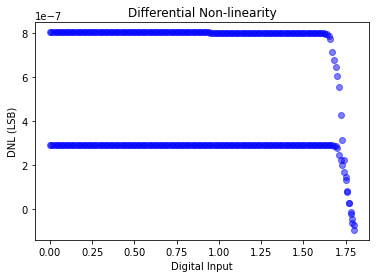

In [181]:
fig, ax = plt.subplots()
ax.plot(my_df["v-sweep"], my_df["i(viout)"], "bo", alpha=0.5)
ax.set_title("Differential Non-linearity")
ax.set_xlabel("Digital Input")
ax.set_ylabel("DNL (LSB)")

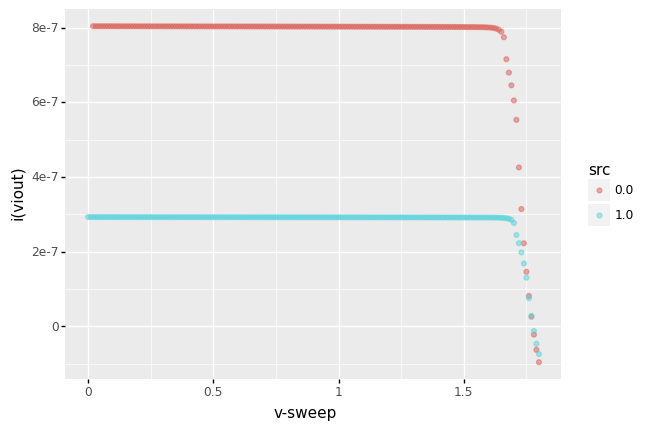

<ggplot: (8758724269544)>

In [182]:
(
    pn.ggplot(my_df.iloc[2:,], pn.aes(x="v-sweep",y="i(viout)", color="src"))
    + pn.geom_point(alpha=0.5)
)

In [3]:
LW_pairs = ([
    (0.25, 12), (0.5, 12), (3, 12),
    (0.25, 9), (0.5, 9), (3, 9),
    (0.25, 6), (0.5, 6), (3, 6),
    (0.25, 4), (0.5, 4), (3, 4),
    (0.25, 3), (0.5, 3), (3, 3),
    (0.25, 1), (0.5, 1), (3, 1),
])

In [4]:
L_list = []
W_list = []
per_list = []
for each in LW_pairs:
    L_list.append(each[0])
    W_list.append(each[1])
    my_df, my_per = import_vsweep(fpath="schematic/data/dac7_L"+str(each[0])+"W"+str(each[1])+"vout-", num=2)
    per_list.append(my_per[0])
df_per = pd.DataFrame({
    "W": np.array(W_list),
    "L": np.array(L_list),
    "Per": np.array(per_list).flatten()
})

In [9]:
%matplotlib notebook

<IPython.core.display.Javascript object>


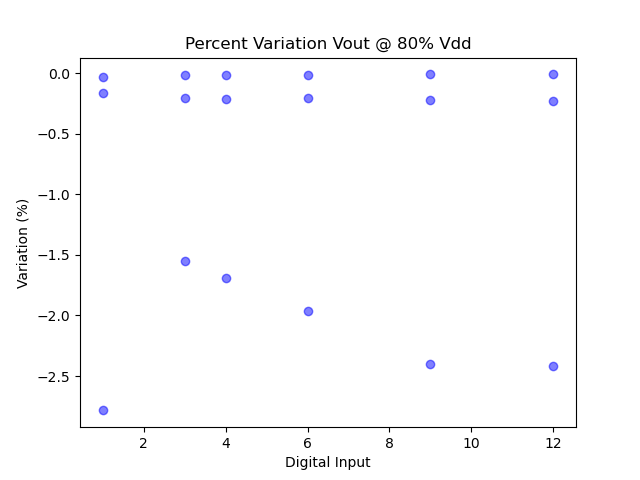

Text(0, 0.5, 'Variation (%)')

In [10]:
fig, ax = plt.subplots()
ax.plot(W_list, per_list, "bo", alpha=0.5)
ax.set_title("Percent Variation Vout @ 80% Vdd")
ax.set_xlabel("Digital Input")
ax.set_ylabel("Variation (%)")

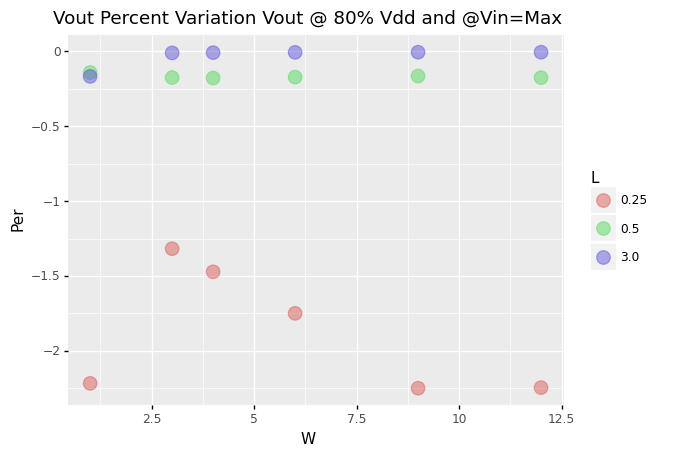

<ggplot: (8773282507135)>

In [6]:
df_per["L"] = df_per["L"].astype(str)
# df_per["W"] = df_per["W"].astype(str)
(
    pn.ggplot(df_per, pn.aes(x="W",y="Per", color="L"))
    + pn.geom_point(alpha=0.5, size=5)
    + pn.labs(
        title = "Vout Percent Variation Vout @ 80% Vdd and @Vin=Max"
    )
)

In [7]:
L_list = []
W_list = []
per_list = []
for each in LW_pairs:
    L_list.append(each[0])
    W_list.append(each[1])
    my_df, my_per = import_vsweep(fpath="schematic/data/dac7_L"+str(each[0])+"W"+str(each[1])+"vout-", num=2)
    per_list.append(my_per[1])
df_per = pd.DataFrame({
    "W": np.array(W_list),
    "L": np.array(L_list),
    "Per": np.array(per_list).flatten()
})

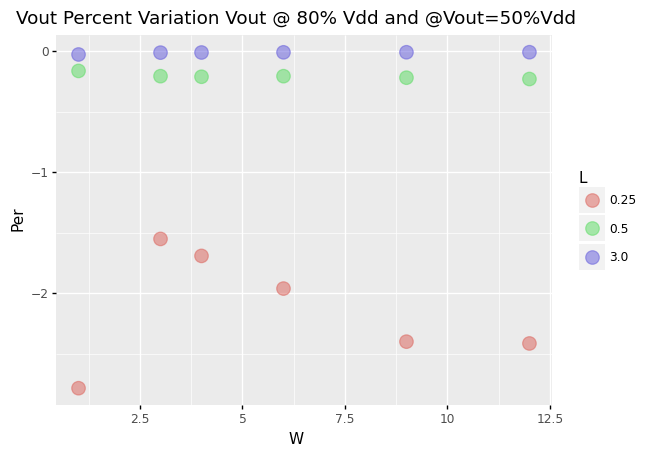

<ggplot: (8773282550348)>

In [8]:
df_per["L"] = df_per["L"].astype(str)
# df_per["W"] = df_per["W"].astype(str)
(
    pn.ggplot(df_per, pn.aes(x="W",y="Per", color="L"))
    + pn.geom_point(alpha=0.5, size=5)
    + pn.labs(
        title = "Vout Percent Variation Vout @ 80% Vdd and @Vout=50%Vdd"
    )
)

In [ ]:
L_list = []
W_list = []
per_list = []
for each in LW_pairs:
    L_list.append(each[0])
    W_list.append(each[1])
    my_df, my_per = import_vsweep(fpath="schematic/data/dac7_L"+str(each[0])+"W"+str(each[1])+"v-", num=2)
    per_list.append(my_per[1])
df_per = pd.DataFrame({
    "W": np.array(W_list),
    "L": np.array(L_list),
    "Per": np.array(per_list).flatten()
})
df_per["L"] = df_per["L"].astype(str)
(
    pn.ggplot(df_per, pn.aes(x="W",y="Per", color="L"))
    + pn.geom_point(alpha=0.5, size=5)
    + pn.labs(
        title = "Vout Percent Variation Vout @ 80% Vdd and @Vout=50%Vdd"
    )
)